In [9]:
import nipype
import os,glob,sys,shutil
sys.path.append("/usr/lib/ants/")
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.interfaces.io as nio
import nipype.interfaces.ants.legacy as antsL
import nipype.interfaces.ants as ants
from nipype.interfaces.ants import Registration
from nipype.interfaces.ants import RegistrationSynQuick
from IPython.display import Image
from nipype.interfaces.fsl import Info
from nipype.interfaces.ants import ApplyTransforms
from nipype import config

from os.path import join as opj
#from nipype.caching import Memory
MNI_template = Info.standard_image('MNI152_T1_1mm_brain.nii.gz')
from nipype import config

cfg = dict(execution={'remove_unnecessary_outputs': False,
                     'keep_inputs': True})
config.update_config(cfg) 

#mem = Memory(base_dir='/data/HCP_Data/NipypeScratch/')
regScratchDir = "/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/"

In [3]:
# """
# Setup for DataGrabber inputs needed for the registration pipeline; This is using the freesurfer nodif and t1 masks
# """
ds = nio.DataGrabber(infields=['subject_id'],
    outfields=['nodif_brain','nodif_brain_mask','struct','struct_mask','struct_brain'])

datasource = pe.Node(interface=ds,name="datasource")
# create a node to obtain the functional images
datasource.inputs.base_directory = "/data/HCP_BedpostData/"
datasource.inputs.template ='*'
datasource.inputs.sort_filelist = True
datasource.inputs.field_template = dict(
    nodif_brain='%s/T1w/Diffusion/nodif_brain.nii*',
    nodif_brain_mask='%s/T1w/Diffusion/nodif_brain_mask.nii*',
    struct='%s/T1w/T1w_acpc_dc.nii*',
    struct_mask='%s/T1w/brainmask_fs.nii*', 
    struct_brain='%s/T1w/T1w_acpc_dc_masked.nii*'
)

# datasource.base_dir="/data/HCP_Data/NipypeScratch/datasource_cache_v2"
datasource.inputs.template_args = dict(
             nodif_brain = [['subject_id']],
             nodif_brain_mask =  [['subject_id']],
             struct =  [['subject_id']],
             struct_mask = [['subject_id']],
             struct_brain = [['subject_id']] )

In [4]:
subjRootDir = "/data/HCP_BedpostData/"
FULL_SUBJECT_LIST = [x for x in os.listdir(subjRootDir) if os.path.isdir( subjRootDir+x+'/T1w/Diffusion.bedpostX')]
print(len(FULL_SUBJECT_LIST),"Subjects are potentially available to be processed!")

1007 Subjects are potentially available to be processed!


In [14]:
"""
Setup for Registration  Pipeline InfoSource i.e. subjects
"""
subj_infosource = pe.Node(interface=util.IdentityInterface(fields=['subject_id']),  name="subj_infosource")
#infosource.iterables = ('subject_id', SampleSubjList)
subj_infosource.iterables = ('subject_id', FULL_SUBJECT_LIST[:2])
### Above just converts the list of subjects into an iterable list I can connect to the next part of the pipeline

In [15]:
#roi = "/data/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz"
roiList = glob.glob("/data/EHECHT_ROIS/Human_*nii.gz")

#The way you would run your different steps is the following:
#1) A is your moving image, B is your fixed image.
#antsRegistrationSyNQuick.sh -d 3 -f B.nii.gz -m A.nii.gz -o RegA2B

#### OF DTI -- >  Struct Brain    using RegSynQuick
## a = dti (MOVING) AND b  =  sTRUCT (fIXED)
reg_DTI_to_Struct = pe.Node( RegistrationSynQuick(
                             num_threads=5,
                             output_prefix="dtiToStruct"),
                             name='reg_DTI_to_Struct')

# 2) B is your moving image, C is your fixed image
# antsRegistrationSyNQuick.sh -d 3 -f C.nii.gz -m B.nii.gz -o RegB2C
# B is Struct and C is MNI
reg_Struct_to_MNI = pe.Node( RegistrationSynQuick(
                             num_threads=5, fixed_image=MNI_template,output_prefix="structToMNI"),
                             name='reg_Struct_to_MNI')

warp_ROIs_MNI_to_DTI = pe.MapNode( ApplyTransforms(invert_transform_flags = [True,True],
                                    interpolation='NearestNeighbor',
                                    ), iterfield=['input_image'], name="warp_ROIs_MNI_to_DTI")

print(roiList)

warp_ROIs_MNI_to_DTI.iterables = ('input_image', roiList)


datasink = pe.Node(nio.DataSink(), name='datasink')
datasink.inputs.base_directory = '/data/HCP_BedpostData/addlInfo/'

datasink.inputs.substitutions = [ ('_subject_id_', ''), ('_input_image_..data..EHECHT_ROIS..', 'DTI_ROIs/'),
                                 ('Human_BasalForebrain_Bilat.nii.gz/',''),
                                 ('Human_BasalForebrain_Left.nii.gz/',''),
                                 ('Human_BasalForebrain_Right.nii.gz/',''),
                                 ('Human_Hypothalamus_Right.nii.gz/',''),
                                 ('Human_Hypothalamus_Left.nii.gz/',''),
                                 ('Human_Hypothalamus_Bilat.nii.gz/','')
                                ]



['/data/EHECHT_ROIS/Human_BasalForebrain_Bilat.nii.gz', '/data/EHECHT_ROIS/Human_BasalForebrain_Left.nii.gz', '/data/EHECHT_ROIS/Human_BasalForebrain_Right.nii.gz', '/data/EHECHT_ROIS/Human_Hypothalamus_Bilat.nii.gz', '/data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz', '/data/EHECHT_ROIS/Human_Hypothalamus_Right.nii.gz', '/data/EHECHT_ROIS/Human_BA17_bilat.nii.gz', '/data/EHECHT_ROIS/Human_BA_4ap_bilat.nii.gz', '/data/EHECHT_ROIS/Human_Bilat_Accumbens_HarvardOxford-sub-maxprob-thr25-1mm.nii.gz']


In [16]:
merge_DTI_to_MNI_xfms = pe.Node(util.Merge(4), name='merge_MNI_to_DTI_xfms')


run_hcp_reg  = pe.Workflow(name="run_hcp_reg_pipeline_redo")
run_hcp_reg.base_dir = regScratchDir

### Conneccts list ofls -al subjects to the data source generator
run_hcp_reg.connect(subj_infosource,'subject_id',datasource,'subject_id')

## Connect inputs for registering the DTI to Structural Image (Rigid Registration)
run_hcp_reg.connect( datasource,'struct_brain',reg_DTI_to_Struct,'fixed_image')
run_hcp_reg.connect( datasource,'nodif_brain',reg_DTI_to_Struct,'moving_image')

## Connect the inputs for registering Structural to MNI 1mm template-- template is specified in fxn
run_hcp_reg.connect( datasource,'struct_brain',reg_Struct_to_MNI,'moving_image')



run_hcp_reg.connect( reg_Struct_to_MNI, "out_matrix",merge_DTI_to_MNI_xfms, "in1"   )
run_hcp_reg.connect( reg_Struct_to_MNI, "inverse_warp_field", merge_DTI_to_MNI_xfms, "in2"    )


run_hcp_reg.connect( reg_DTI_to_Struct, "out_matrix",merge_DTI_to_MNI_xfms, "in3"   )
run_hcp_reg.connect( reg_DTI_to_Struct, "inverse_warp_field",merge_DTI_to_MNI_xfms, "in4"   )

# 4) Moving from C to A space:
# antsApplyTransforms -d 3 -i C.nii.gz -o CDeformed.nii.gz -r A.nii.gz -t [RegA2B0GenericAffine.mat,1] -t RegA2B1InverseWarp.nii.gz -t [RegB2C0GenericAffine.mat,1] -t RegB2C1InverseWarp.nii.gz

# 3) Moving A to C space:
# antsApplyTransforms -d 3 -i A.nii.gz -o ADeformed.nii.gz -r C.nii.gz -t RegB2C1Warp.nii.gz  -t RegB2C0GenericAffine.mat -t RegA2B1Warp.nii.gz -t RegA2B0GenericAffine.mat

## So order of matrices being applied is inverse warp field(S->M), affine (S-M) Inverted, then Affine(DTI->S) Inverted


# The transforms are always listed from the last one begin computed (closest to the fixed images space) to the first one being computed (closest to the moving image space) since they are backward transforms.



run_hcp_reg.connect( merge_DTI_to_MNI_xfms,  'out', warp_ROIs_MNI_to_DTI, 'transforms')
run_hcp_reg.connect( datasource, 'nodif_brain', warp_ROIs_MNI_to_DTI, 'reference_image')

### Copy the files to a datasink
run_hcp_reg.connect(subj_infosource,'subject_id',datasink,'subject')
    
run_hcp_reg.connect(warp_ROIs_MNI_to_DTI,'output_image',datasink,'subject.@ROIs')

run_hcp_reg.connect(reg_Struct_to_MNI,'forward_warp_field',datasink,'subject.@fwd_warp')
run_hcp_reg.connect(reg_Struct_to_MNI,'inverse_warp_field',datasink,'subject.@inv_warp')
run_hcp_reg.connect(reg_Struct_to_MNI,'out_matrix',datasink,'subject.@affine_mtx')

run_hcp_reg.connect( reg_DTI_to_Struct, "out_matrix",datasink, "subject.@dtiToStructMat"   )

run_hcp_reg.connect( warp_ROIs_MNI_to_DTI,"output_image",datasink,"subject.@roisInDTISpace")

run_hcp_reg.run(plugin='MultiProc', plugin_args={'n_procs' : 40})

190214-17:40:04,119 workflow INFO:
	 Workflow run_hcp_reg_pipeline_redo settings: ['check', 'execution', 'logging', 'monitoring']
190214-17:40:04,271 workflow INFO:
	 Running in parallel.
190214-17:40:04,278 workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 169.98/169.98, Free processors: 40/40.
190214-17:40:04,403 workflow INFO:
	 [Node] Setting-up "run_hcp_reg_pipeline_redo.datasource" in "/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/_subject_id_112516/datasource".
190214-17:40:04,407 workflow INFO:
	 [Node] Setting-up "run_hcp_reg_pipeline_redo.datasource" in "/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/_subject_id_379657/datasource".
190214-17:40:04,420 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
190214-17:40:04,423 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
190214-17:40:04,439 workflow INFO:
	 [Node] Finished "run

	 [Node] Setting-up "run_hcp_reg_pipeline_redo.warp_ROIs_MNI_to_DTI" in "/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/_subject_id_112516/_input_image_..data..EHECHT_ROIS..Human_BasalForebrain_Right.nii.gz/warp_ROIs_MNI_to_DTI".190214-17:40:10,454 workflow INFO:
	 [Node] Setting-up "_warp_ROIs_MNI_to_DTI0" in "/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/_subject_id_112516/_input_image_..data..EHECHT_ROIS..Human_Hypothalamus_Bilat.nii.gz/warp_ROIs_MNI_to_DTI/mapflow/_warp_ROIs_MNI_to_DTI0".190214-17:40:10,455 workflow WARNING:
	 [Node] Error on "_warp_ROIs_MNI_to_DTI0" (/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/_subject_id_112516/_input_image_..data..EHECHT_ROIS..Human_Hypothalamus_Left.nii.gz/warp_ROIs_MNI_to_DTI/mapflow/_warp_ROIs_MNI_to_DTI0)


190214-17:40:10,461 workflow WARNING:
	 [Node] Error on "run_hcp_reg_pipeline_redo.warp_ROIs_MNI_to_DTI" (/data/NipypeScratch/run_hcp_reg_pipeline_add

	 [Node] Error on "run_hcp_reg_pipeline_redo.warp_ROIs_MNI_to_DTI" (/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/_subject_id_379657/_input_image_..data..EHECHT_ROIS..Human_BA_4ap_bilat.nii.gz/warp_ROIs_MNI_to_DTI)
190214-17:40:10,549 workflow INFO:
	 [Node] Setting-up "run_hcp_reg_pipeline_redo.warp_ROIs_MNI_to_DTI" in "/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/_subject_id_379657/_input_image_..data..EHECHT_ROIS..Human_Hypothalamus_Left.nii.gz/warp_ROIs_MNI_to_DTI".190214-17:40:10,551 workflow INFO:
	 [Node] Setting-up "_warp_ROIs_MNI_to_DTI0" in "/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/_subject_id_379657/_input_image_..data..EHECHT_ROIS..Human_Hypothalamus_Right.nii.gz/warp_ROIs_MNI_to_DTI/mapflow/_warp_ROIs_MNI_to_DTI0".190214-17:40:10,552 workflow WARNING:
	 [Node] Error on "_warp_ROIs_MNI_to_DTI0" (/data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/_subject_id_3

190214-17:40:12,295 workflow ERROR:
	 Node warp_ROIs_MNI_to_DTI.aI.a7.b1 failed to run on host 30d275094f09.
190214-17:40:12,296 workflow ERROR:
	 Saving crash info to /data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/crash-20190214-174012-neuro-warp_ROIs_MNI_to_DTI.aI.a7.b1-b13bffb2-3334-48ea-ba9a-25cedc69d875.pklz
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 68, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1259, in _run_interface
    self.config['execution']['stop_on_first_crash'])))
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1181, in _collate_results
    (self.name, '\n'.join(msg)))
Exception: Subnodes of node

190214-17:40:12,312 workflow ERROR:
	 Node warp_ROIs_MNI_to_DTI.aI.a3.b1 failed to run on host 30d275094f09.
190214-17:40:12,314 workflow ERROR:
	 Saving crash info to /data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/crash-20190214-174012-neuro-warp_ROIs_MNI_to_DTI.aI.a3.b1-97c5934f-fce5-4680-8cf4-f3240b3785e8.pklz
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 68, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1259, in _run_interface
    self.config['execution']['stop_on_first_crash'])))
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1181, in _collate_results
    (self.name, '\n'.join(msg)))
Exception: Subnodes of node

190214-17:40:12,329 workflow ERROR:
	 Node warp_ROIs_MNI_to_DTI.aI.a8.b0 failed to run on host 30d275094f09.
190214-17:40:12,331 workflow ERROR:
	 Saving crash info to /data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/crash-20190214-174012-neuro-warp_ROIs_MNI_to_DTI.aI.a8.b0-0c6c5c67-34d0-4287-b6d4-47d9503f8761.pklz
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 68, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1259, in _run_interface
    self.config['execution']['stop_on_first_crash'])))
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1181, in _collate_results
    (self.name, '\n'.join(msg)))
Exception: Subnodes of node

190214-17:40:12,346 workflow ERROR:
	 Node warp_ROIs_MNI_to_DTI.aI.a4.b0 failed to run on host 30d275094f09.
190214-17:40:12,348 workflow ERROR:
	 Saving crash info to /data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/crash-20190214-174012-neuro-warp_ROIs_MNI_to_DTI.aI.a4.b0-b65d7743-061b-432d-bd98-e18c8a55be65.pklz
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 68, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1259, in _run_interface
    self.config['execution']['stop_on_first_crash'])))
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1181, in _collate_results
    (self.name, '\n'.join(msg)))
Exception: Subnodes of node

190214-17:40:12,363 workflow ERROR:
	 Node warp_ROIs_MNI_to_DTI.aI.a0.b0 failed to run on host 30d275094f09.
190214-17:40:12,365 workflow ERROR:
	 Saving crash info to /data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/crash-20190214-174012-neuro-warp_ROIs_MNI_to_DTI.aI.a0.b0-b3bd4f23-3166-42c0-9c66-7114799941d7.pklz
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 68, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1259, in _run_interface
    self.config['execution']['stop_on_first_crash'])))
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 1181, in _collate_results
    (self.name, '\n'.join(msg)))
Exception: Subnodes of node

190214-17:40:14,321 workflow INFO:
	 ***********************************


RuntimeError: Workflow did not execute cleanly. Check log for details

181013-15:13:39,571 workflow INFO:
	 Generated workflow graph: /data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/graph.png (graph2use=hierarchical, simple_form=True).


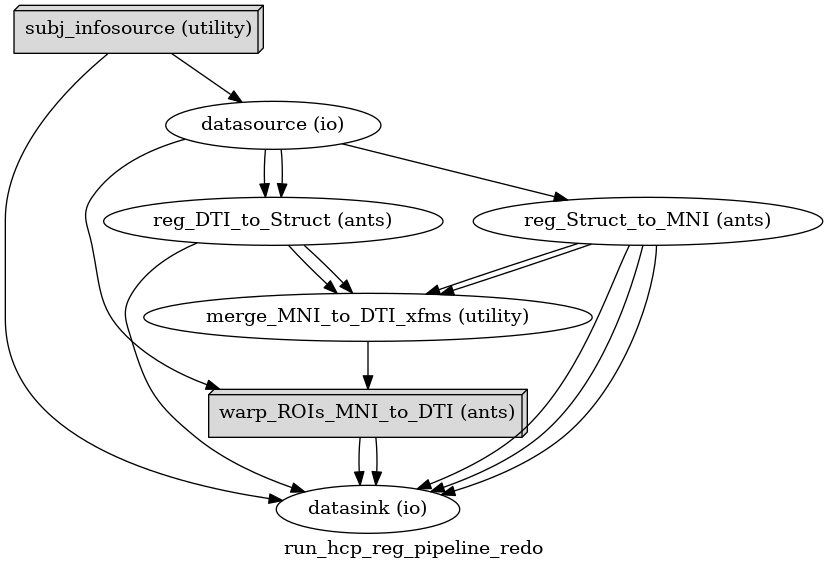

In [7]:

run_hcp_reg.write_graph()
Image('/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline_addwarp/run_hcp_reg_pipeline_redo/graph.png')                    
#  (antsreg, datasink, [('warped_image',
#                                         'antsreg.@warped_image'),                    
                    
## I think I need to do a merge pipeline to create a list                    
                    
# forward_warp_field: (an existing file name)
#         Forward warp field
# inverse_warp_field: (an existing file name)
#         Inverse warp field
# inverse_warped_image: (an existing file name)
#         Inverse warped image
# out_matrix: (an existing file name)
#         Affine matrix
# warped_image: (an existing file name)
#         Warped image

# ref = "/data/HCP_Data/HCP_BedpostData/100206/T1w/Diffusion/nodif_brain.nii.gz"
# roi = "/data/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz"

# mni_to_struct_warp = "/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/_subject_id_100206/reg_Struct_to_MNI/transform1InverseWarp.nii.gz"

# dti_to_struct_matrix= "/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/_subject_id_100206/reg_DTI_to_Struct/transform0GenericAffine.mat"
# ### This needs to be inverted when I apply it


# #WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz

# wimt = WarpImageMultiTransform()
# wimt.inputs.input_image = roi
# wimt.inputs.reference_image = ref
# wimt.inputs.transformation_series = [dti_to_struct_matrix,mni_to_struct_warp]
# wimt.inputs.invert_affine = [1]
# wimt.cmdline
#run_hcp_reg.run()

In [ ]:
ref = "/data/HCP_Data/HCP_BedpostData/100206/T1w/Diffusion/nodif_brain.nii.gz"
roi = "/data/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz"

mni_to_struct_warp = "/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/_subject_id_100206/reg_Struct_to_MNI/transform1InverseWarp.nii.gz"

dti_to_struct_matrix= "/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/_subject_id_100206/reg_DTI_to_Struct/transform0GenericAffine.mat"
### This needs to be inverted when I apply it


#WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz
from nipype.interfaces.ants import WarpImageMultiTransform
wimt = WarpImageMultiTransform()
wimt.inputs.input_image = roi
wimt.inputs.reference_image = ref
wimt.inputs.transformation_series = [dti_to_struct_matrix,mni_to_struct_warp]
wimt.inputs.invert_affine = [1]
wimt.cmdline
# 'WarpImageMultiTransform 3 structural.nii structural_wimt.nii -R ants_deformed.nii.gz ants_Warp.nii.gz ants_Affine.txt'
# >>> wimt = WarpImageMultiTransform()
# >>> wimt.inputs.input_image = 'diffusion_weighted.nii'
# >>> wimt.inputs.reference_image = 'functional.nii'
# >>> wimt.inputs.transformation_series = ['func2anat_coreg_Affine.txt','func2anat_InverseWarp.nii.gz',     'dwi2anat_Warp.nii.gz','dwi2anat_coreg_Affine.txt']
# >>> wimt.inputs.invert_affine = [1]  # this will invert the 1st Affine file: 'func2anat_coreg_Affine.txt'
# >>> wimt.cmdline
# 'WarpImageMultiTransform 3 diffusion_weighted.nii diffusion_weighted_wimt.nii -R functional.nii -i func2anat_coreg_Affine.txt func2anat_InverseWarp.nii.gz dwi2anat_Warp.nii.gz dwi2anat_coreg_Affine.txt'

# #d_to_s_op= lambda x: str(os.path.join(regScratchDir,str(x),"%s_DTI_to_Struct_" % x))
# d_to_s_op= lambda x: ("/data/HCP_Data/NipypeScratch/run_hcp_reg/%s/%s_DTI_to_Struct_" % (x,x))

res = wimt.run()
#WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz
res.outputs

In [ ]:
#reg_DTI_to_Struct = mem.cache(RegistrationSynQuick)

# for subjID in completeSubjs:
#     subjWD = os.path.join(regScratchDir,str(subjID))
#     if not os.path.isdir(subjWD):
#         os.makedirs(subjWD)

#     ### DTI -->  STRUCT
#     struct_brain = '/data/HCP_Data/HCP_BedpostData/%s/T1w/T1w_acpc_dc_masked.nii.gz' % subjID
#     nodif_brain = '/data/HCP_Data/HCP_BedpostData/%s/T1w/Diffusion/nodif_brain.nii.gz' % subjID
#     MNI_1MM = '/usr/share/fsl/5.0/data/standard/MNI152_T1_1mm_brain.nii.gz'

#     d_to_s_op= os.path.join(regScratchDir,str(subjID),"%s_DTI_to_Struct_" % subjID)
#     s_to_MNI_1mm_op = os.path.join(regScratchDir,str(subjID),"%s_Struct_to_MNI_1mm_" % subjID)
    
#     reg_DTI_to_Struct(moving_image=nodif_brain,fixed_image=struct_brain,num_threads=24,
#                       transform_type='r',output_prefix=d_to_s_op)
    
#     #### Struct --> MNI
#     reg_Struct_to_MNI(moving_image=struct_brain,fixed_image=MNI_1MM,num_threads=24,
#                      output_prefix=s_to_MNI_1mm_op)
    
#     ## TO DO-- COMBINE ROIS

In [ ]:
#roi_datasink.inputs.substitutions = datasink.inputs.substitutions

# substitutions=[]
# for i in range(len(FULL_SUBJECT_LIST[:2])):
#     substitutions+= [("_neck_remove"+str(i), subject_list[i])]
#     substitutions+= [("subject_id_", "")]
# sink.inputs.substitutions =substitutions 

#https://gist.github.com/Crisly/10395192
# Concatenate DTI_to_Struct and Struct_to_MNI into a list
#merge_xfms = pe.Node(util.Merge(3), iterfield=['in3'], name='merge_xfms')

In [ ]:
reg_DTI_to_Struct.cmdline
#/usr/lib/ants/ANTS 3 -m PR[MNI152_T1_1mm_brain.nii.gz,T1w_acpc_dc_masked.nii.gz,1,4] 
# -t SyN[0.25] -r Gauss[3,0] -o T1_to_MNI_ -i 30x90x20 --use-Histogram-Matching 
# --number-of-affine-iterations 10000x10000x10000x10000x10000 --MI-option 32x16000


In [ ]:
# wi = result.outputs.warped_image
# from niwidgets import NiftiWidget
# from niwidgets import examplet1

# test_widget = NiftiWidget(wi)
# test_widget.nifti_plotter()


# fixed_widget = NiftiWidget( "/data/HCP_Data/HCP_BedpostData/100206/T1w/T1w_acpc_dc_masked.nii.gz")
# fixed_widget.nifti_plotter()

In [ ]:
### Concepts/Steps

## 3 Spaces     DTI    ---- >    T1        --->MNI
## DTI is probably "best" registered using the nodif_brain which is the first image of the "data.nii.gz" file
#antsIntroduction.sh -d 3 -r $MNI_BRAIN  -i $T1_BRAIN -o T1_to_MNI_ -t GR


In [ ]:
# DTI='/data/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/data.nii.gz'
# DTI_B0='/data/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/nodif_brain.nii.gz'
# DTI_M='/data/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/nodif_brain_mask.nii.gz'
# T1_M='/data/HCP_Data/HCP_BedpostData/100610/T1w/brainmask_fs.nii.gz'
# T1='/data/HCP_Data/HCP_BedpostData/100610/T1w/T1w_acpc_dc.nii.gz'
# # DTI_TO_T1='/data/HCP_Data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/sampleAntsRegData/nodif_to_T1_deformed.nii.gz
# MNI_BRAIN='/usr/share/fsl/5.0/data/standard/MNI152_T1_1mm_brain.nii.gz'
# #T1_BRAIN=''/HCP_Data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/sampleAntsRegData/T1w_acpc_dc_masked.nii.gz
# ROI_ONE='/data/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz' 


In [ ]:

# echo $IN $T1_M $T1

# ## NOTES PROBABLY wouLD bE QUICKER IF WE USED THE T1 IMAGE WIHT THE MASK APPLIED... TO DO!!

# export PATH=$PATH:/usr/lib/ants
# export ANTSPATH=/usr/lib/ants

# ## Get the first B0 image from the DTI data set
# #fslroi $DTI $DTI_B0 0 1 


# ## Register the B0/DTI image to the T1 --- we perhaps should have used the masked/brainonly T1??
# #antsIntroduction.sh -d 3 -r $T1 -i $DTI_B0 -o nodif_to_T1_ -t RI


# ## Need to apply the brain mask to the T1 image to speed things up
# #fslmaths $T1 -mas $T1_M $T1_MASKED


# ### Thsi registers the T1 Brain image nonlinearly to MNI Space.. and also generated the inverse warp
# #antsIntroduction.sh -d 3 -r $MNI_BRAIN  -i $T1_BRAIN -o T1_to_MNI_ -t GR

# ### note T1_To_MNI_Warp is the warp transform.. and we add two affine matrices which are also real files
# #WarpImageMultiTransform 3 $DTI_B0  nodif_to_MNI_test.nii.gz -R $MNI_BRAIN  T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt nodif_to_T1_Affine.txt


# ### THIS GOES IN REVERSE
# WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz
# WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI_NN.nii.gz -R $DTI_B0 --use-NN -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz

# ## --use-NN: Use Nearest Neighbor Interpolation. 
 
# #runpbx.connect(subj_infosource,'subject_id',datasource,'subject_id')
# runpbx2  = pe.Workflow(name="runpbx2_gpu")
# runpbx2.base_dir = "/data/NipypeScratch/"

# samples_base_name_fxn = lambda x : x.replace('_th1samples.nii.gz','')


# runpbx2.connect(subj_infosource,'subject_id',datasource,'subject_id')
# # ### Connect the dti_datasource to the pbx2 command
# runpbx2.connect( datasource,'thsamples',pbx2,'thsamples')
# runpbx2.connect( datasource,'phsamples',pbx2,'phsamples')
# runpbx2.connect( datasource,'fsamples',pbx2,'fsamples')
# runpbx2.connect( datasource,'nodif_brain_mask',pbx2,'mask')
# runpbx2.connect( datasource, ('thsamples', samples_base_name_fxn ), pbx2,'samples_base_name') ###  NOTE THIS IS A WEIRD TUPLE IS

# # runpbx2.run()
# runpbx2.run(plugin='MultiProc', plugin_args={'n_procs' : 1})

#run_hcp_reg.connect( subj_infosource,('subject_id',d_to_s_op),reg_DTI_to_Struct,'output_prefix')

# runpbx2.connect( datasource,'fsamples',pbx2,'fsamples')
# runpbx2.connect( datasource,'nodif_brain_mask',pbx2,'mask')
# runpbx2.connect( datasource, ('thsamples', samples_base_name_fxn ), pbx2,'samples_base_name') ###  NOTE THIS IS A WEIRD TUPLE IS
    

END PRODUCT:   We will create a directory in Diffusion or maybe ROIs and maybe a subdirectory called DTI
    
    so /{SubjID}/T1w/ROIs/DTI_Space/Human_L_Hypothalamus.nii
       /{SubjID}/xfms/<<PUT XFMS HERE>> 
        

In [ ]:
I looked again at ANTs documentation to see if my recollection was correct. Talking about transforms and order can be pretty confusing in image processing as transforms are backward transforms (as opposed to forward transforms when transforming point clouds for example).

To try to be clear in my explanation, I will always specify the moving image and fixed image, as well as the reference/target space, which is often the fixed image space.
Both the old way of using ANTs (ANTS with WarpImageMultiTransform) or the new way using antsRegistration (antsRegistration with  antsApplyTransforms), with antsRegistrationSyNQuick.sh being a script wrapping antsRegistration, expect the transforms in the same order, which makes it easier :)

The way you would run your different steps is the following:
1) A is your moving image, B is your fixed image.
antsRegistrationSyNQuick.sh -d 3 -f B.nii.gz -m A.nii.gz -o RegA2B
2) B is your moving image, C is your fixed image
antsRegistrationSyNQuick.sh -d 3 -f C.nii.gz -m B.nii.gz -o RegB2C
3) Moving A to C space:
antsApplyTransforms -d 3 -i A.nii.gz -o ADeformed.nii.gz -r C.nii.gz -t RegB2C1Warp.nii.gz  -t RegB2C0GenericAffine.mat -t RegA2B1Warp.nii.gz -t RegA2B0GenericAffine.mat
4) Moving from C to A space:
antsApplyTransforms -d 3 -i C.nii.gz -o CDeformed.nii.gz -r A.nii.gz -t [RegA2B0GenericAffine.mat,1] -t RegA2B1InverseWarp.nii.gz -t [RegB2C0GenericAffine.mat,1] -t RegB2C1InverseWarp.nii.gz

The transforms are always listed from the last one begin computed (closest to the fixed images space) to the first one being computed (closest to the moving image space) since they are backward transforms.

You can find more information in:
https://raw.githubusercontent.com/stnava/ANTsDoc/master/ants2.pdf (page 15. Beware, their example in inverted compare to this example: Fixed image is C, reference is A)

Hope this helps,
Francois





### Start with the MNI-space hypothalamus / basal forebrain ROIs à want to end up with tractography in all subjects in MNI space

 

Compute rigid body transform from diffusion space to T1

antsIntroduction.sh -d 3 -r T1.nii.gz -i nodif.nii.gz -o nodif_to_T1_ -t RI

 

Compute nonlinear warp from T1 to MNI

antsIntroduction.sh -d 3 -r MNI.nii.gz -i T1.nii.gz -o T1_to_MNI_ -t GR

(I think GR (greedy Syn) should be faster than SY (Syn) which is the default and apparently I’ve been using GR with good results so far)

 

Apply transformations so you can check that it all looks OK

WarpImageMultiTransform 3 nodif.nii.gz nodif_to_MNI.nii.gz -R MNI.nii.gz T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt DTI_to_T1_Affine.txt

Then check that nodif-to-MNI mappings look good: slicesdir –p MNI_template.nii.gz Subj_*_nodif_to_MNI.nii.gz

 

Apply INVERSE transformation from MNI-space ROIs to individual subjects’ diffusion space

WarpImageMultiTransform 3 template_ROI.nii.gz SubjX_ROI.nii.gz –R nodif.nii.gz –i DTI_to_T1_Affine.txt –i T1_to_MNI_Affine.txt T1_to_MNI_InverseWarp.nii.gz

 

Run probtrackx using native-space ROIs… this will produce a native-space fdt_paths.nii.gz file.  Threshold and normalize in native space.

 

Apply transformations to get thresholded, normalized tracts into MNI space

WarpImageMultiTransform 3 fdt_paths_thresh_norm.nii.gz SubjX_fdt_paths_thresh_norm_in_MNIspace.nii.gz -R MNI.nii.gz T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt DTI_to_T1_Affine.txt

 

Fslmerge –t Subj*_fdt_paths_thresh_norm_in_MNIspace.nii.gz à this becomes the input for randomise

 

In [ ]:
DTI=/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/data.nii.gz
DTI_B0=/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/nodif_brain.nii.gz
DTI_M=/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/nodif_brain_mask.nii.gz
T1_M=/HCP_Data/HCP_BedpostData/100610/T1w/brainmask_fs.nii.gz
T1=/HCP_Data/HCP_BedpostData/100610/T1w/T1w_acpc_dc.nii.gz
DTI_TO_T1=/HCP_Data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/sampleAntsRegData/nodif_to_T1_deformed.nii.gz
MNI_BRAIN=/usr/share/fsl/5.0/data/standard/MNI152_T1_1mm_brain.nii.gz 

T1_BRAIN=/HCP_Data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/sampleAntsRegData/T1w_acpc_dc_masked.nii.gz

ROI_ONE=/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz  


echo $IN $T1_M $T1

## NOTES PROBABLY wouLD bE QUICKER IF WE USED THE T1 IMAGE WIHT THE MASK APPLIED... TO DO!!

export PATH=$PATH:/usr/lib/ants
export ANTSPATH=/usr/lib/ants

## Get the first B0 image from the DTI data set
#fslroi $DTI $DTI_B0 0 1 


## Register the B0/DTI image to the T1 --- we perhaps should have used the masked/brainonly T1??
#antsIntroduction.sh -d 3 -r $T1 i $DTI_B0 -o nodif_to_T1_ -t RI


## Need to apply the brain mask to the T1 image to speed things up
#fslmaths $T1 -mas $T1_M $T1_MASKED


### Thsi registers the T1 Brain image nonlinearly to MNI Space.. and also generated the inverse warp
#antsIntroduction.sh -d 3 -r $MNI_BRAIN  -i $T1_BRAIN -o T1_to_MNI_ -t GR

### note T1_To_MNI_Warp is the warp transform.. and we add two affine matrices which are also real files
#WarpImageMultiTransform 3 $DTI_B0  nodif_to_MNI_test.nii.gz -R $MNI_BRAIN  T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt nodif_to_T1_Affine.txt

### THIS GOES IN REVERSE
WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz
WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI_NN.nii.gz -R $DTI_B0 --use-NN -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz

## --use-NN: Use Nearest Neighbor Interpolation. 
 
#
#Then check that nodif-to-MNI mappings look good: slicesdir –p MNI_template.nii.gz Subj_*_nodif_to_MNI.nii.gz
#Apply INVERSE transformation from MNI-space ROIs to individual subjects’ diffusion space
#WarpImageMultiTransform 3 template_ROI.nii.gz SubjX_ROI.nii.gz –R nodif.nii.gz –i DTI_to_T1_Affine.txt –i T1_to_MNI_Affine.txt T1_to_MNI_InverseWarp.nii.gz
 

#Run probtrackx using native-space ROIs… this will produce a native-space fdt_paths.nii.gz file.  Threshold and normalize in native space.


#Apply transformations to get thresholded, normalized tracts into MNI space

#WarpImageMultiTransform 3 fdt_paths_thresh_norm.nii.gz SubjX_fdt_paths_thresh_norm_in_MNIspace.nii.gz -R MNI.nii.gz T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt DTI_to_T1_Affine.txt

 

#Fslmerge –t Subj*_fdt_paths_thresh_norm_in_MNIspace.nii.gz à this becomes the input for randomi



In [ ]:
To try to be clear in my explanation, I will always specify the moving image and fixed image, as well as the reference/target space, which is often the fixed image space.
Both the old way of using ANTs (ANTS with WarpImageMultiTransform) or the new way using antsRegistration (antsRegistration with  antsApplyTransforms), with antsRegistrationSyNQuick.sh being a script wrapping antsRegistration, expect the transforms in the same order, which makes it easier :)

The way you would run your different steps is the following:
1) A is your moving image, B is your fixed image.
antsRegistrationSyNQuick.sh -d 3 -f B.nii.gz -m A.nii.gz -o RegA2B
2) B is your moving image, C is your fixed image
antsRegistrationSyNQuick.sh -d 3 -f C.nii.gz -m B.nii.gz -o RegB2C
3) Moving A to C space:
antsApplyTransforms -d 3 -i A.nii.gz -o ADeformed.nii.gz -r C.nii.gz -t RegB2C1Warp.nii.gz  -t RegB2C0GenericAffine.mat
         -t RegA2B1Warp.nii.gz -t RegA2B0GenericAffine.mat
4) Moving from C to A space:
antsApplyTransforms -d 3 -i C.nii.gz -o CDeformed.nii.gz -r A.nii.gz -t [RegA2B0GenericAffine.mat,1] -t RegA2B1InverseWarp.nii.gz -t [RegB2C0GenericAffine.mat,1] -t RegB2C1InverseWarp.nii.gz

The transforms are always listed from the last one begin computed (closest to the fixed images space) to the first one being computed (closest to the moving image space) since they are backward transforms.



### Generate DTI To Struct   DTI=Moving (A), Struct=Fixed (B)
antsRegistrationSynQuick.sh -d 3 -f {StructBrain} -m nodifBrain -o RegNoDifToStruct

#Generate Struct to MNI    StructBrain= Moving(B),  MNI = Fixed(C)

antsRegistrationSynQuick.sh -d 3 -f MNI  -m StructBrain -o RegStructToMNI


## Go from A to C  i.e. from noDif to MNI
antsApplyTransforms -d 3 -i nodifBrain -o nodifBrainDeformed -r MNI -t RegStructToMNIWarp -t RegStructoToMNIAffine 
         -t RegNoDifToStructWarp -t RegNoDifToStructAffine.mat
        
## NOW THE REVERSE...
antsApplyTransforms -d 3 -i MNI -o MNI_WarpedToNoDif -r NoDif -t [RegNoDifToStructAffine.mat,1] -t RegNoDifToStructInverseWarp 
      -t [StructToMNIAffine.mat,1] -t StructToMNIInverseWarp
    
    
    
    





